Confirming Peak of Epidemic Curve (CPEC)
========================================

An epidemic curve shows frequency of new cases per day. A peak on that curve means the day when highest number of individuals were found to be infected and post that the frequency reduced. Predicting the peak is of significance since it indicates the maximum number of infected patients requiring care at a time. It can help Government prep the healthcare system and also gives a rough estimate on when the epidemic might end. In this study, we look at a couple of models which are predicting peaks and verify whether their predictions are correct.

Recently, Data Driven Innovation lab (DDI) at Singapore University of Technology and Design (SUTD) came out with a model which tries to provide peak dates for various conuntries: https://www.altaveu.com/documents/covid19predictionpaper20200426.pdf

Similarly, Institute for Health Metrics and Evaluation (IHME) at University of Washington (UW) has come up with models which declare peaks for some countries: https://covid19.healthdata.org/

We'll verify whether the peak dates provided by these two models are correct or not. 
Since the peak is a local maximum, the slope of the curve should hit 0.

In [12]:
import pandas as pd
import numpy as np
from matplotlib.dates import date2num, AutoDateLocator, ConciseDateFormatter, DayLocator, AutoDateFormatter
import time

## Helper methods for computing and plotting peaks

In [2]:
def compute_peak(df, col):
    """Compute peak record wrt to a column 'col' in dataframe 'df'"""

    # calc daily new cases avg and normalise to pct
    df[col + '_pct'] = df[col] / df[col].max() * 100
    
    # calc change in new cases, smoothened over a period of 6 days
    df['avg_' + col + '_pct'] = df[col + '_pct'].rolling(6, min_periods=1, center=True).mean().rolling(6, min_periods=1, center=True).mean()
    df['delta_' + col + '_pct'] = (df['avg_' + col + '_pct'].shift(-3) - df['avg_' + col + '_pct'].shift(3, fill_value=0)) / 6

    # calc slope in degrees, assuming 5 pct per day growth = 45 deg slope. then smoothen over 6 days
    df[col + '_slope'] = np.degrees(np.arctan(df['delta_' + col + '_pct'] / 5))
    df[col + '_slope'] = df[col + '_slope'].rolling(6, min_periods=1, center=True).mean()

    # calc second order change
    df['delta_' + col + '_slope'] = (df[col + '_slope'].shift(-3) - df[col + '_slope'].shift(3, fill_value=0))

    # calc potential peaks, i.e. when slope is 0
    sign_change = np.nonzero(np.abs(np.diff(np.sign(df[col + '_slope'].interpolate(method='pad')))))[0]
    potential_peaks = df.loc[sign_change]

    # filter noise using second order derivative
    potential_peaks = potential_peaks.loc[potential_peaks['delta_' + col + '_slope'] < 0]

    # use highest peak in case multiple peaks found
    peak = potential_peaks.loc[potential_peaks['avg_' + col + '_pct'].idxmax()] if len(potential_peaks) else None

    return peak

In [26]:
def calc_peaks(df, location='India', deaths=True, plot=True, save=False):
    # filter sort and prep data
    grp_df = df.loc[df['location']==location]
    grp_df = grp_df.sort_values(by='date')
    grp_df.reset_index(inplace=True, drop=True)

    # compute peaks
    cols = ['new_cases']
    if deaths:
        cols.append("new_deaths")
    peaks = {}
    for col in cols:
        if grp_df[col].sum() < 50:
            print(col, "sum less than 50. Skipping.")
            continue
        peak = compute_peak(grp_df, col)
        peaks[col] = peak
    
    # return if plotting not required
    if not plot:
        return peaks
    
    # return if cases below threshold
    if 'new_cases' not in peaks:
        return peaks
    
    # plot charts
    y_to_plot = ['avg_new_cases_pct', 'new_cases_slope']
    titles_to_plot = [location + ': Avg % cases', location + ': Slope (in degrees)']
    styles = ['-b', '-b']

    w = 7.5
    h = 3.5 * len(y_to_plot)

    axs = grp_df.plot(
        x = 'date',
        y = y_to_plot,
        title = titles_to_plot,
        color = ['b', 'b'],
        grid = True,
        subplots = True,
        figsize = (w, h), # w x h
        sharex = False
    )

    # add vertical line when peak hit
    if not peaks['new_cases'] is None:
        for ax in axs:
            ax.axvline(x=peaks['new_cases']['date'], linewidth=2, color='b')

    # add death plots if enabled and if above threshold
    if deaths and 'new_deaths' in peaks:
        grp_df.plot(x = 'date', y = 'avg_new_deaths_pct', grid = True, style='-r', ax = axs[0])
        grp_df.plot(x = 'date', y = 'new_deaths_slope', grid = True, style='-r', ax = axs[1])
        if not peaks['new_deaths'] is None:
            for ax in axs:
                ax.axvline(x=peaks['new_deaths']['date'], linewidth=2, color='r')

    # x axis on slope curves
    axs[1].axhline(y = 0, linewidth = 2, color = 'r')
    
    # x axis ticks
    mj_l = AutoDateLocator()
    mj_f = ConciseDateFormatter(mj_l, show_offset=False)
    mn_l = DayLocator()
    for ax in axs:
        ax.xaxis.set_major_formatter(mj_f)
        ax.xaxis.set_minor_locator(mn_l)
    
    # set top chart label to blank
    axs[0].set_xlabel('')
    axs[0].get_figure().tight_layout(pad=1.5)
    
    # save charts to docs folder
    if save:
        axs[0].get_figure().savefig("docs/assets/images/02/" + location.lower().replace(" ", "_") + ".png")
    
    return peaks

## Country Analysis: OWID Data
For this study, we've downloaded country-wise data from "Our World In Data": 
https://ourworldindata.org/coronavirus

In [4]:
cols = ['location', 'date', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths']
dates = ['date']
df = pd.read_csv("csv/owid-covid-data.csv", 
                 usecols=cols,
                 parse_dates=dates)
df.sample()

,location,date,total_cases,new_cases,total_deaths,new_deaths
946,Austria,2020-04-25,15068,83,513,5


For each country, onset date is considered when number of total cases exceeds 100. 

This is done since data from the initial days is usually noisy.

In [5]:
# consider days when total_cases exceeded 100
fdf = df.loc[df['total_cases']>100]

In [6]:
# Data from University of Washington and Singapore University of Technology and Design
COUNTRY_DATA = [
    {"location": "India", "uw_peak": "", "sutd_peak": "2020-04-20"},
    {"location": "China", "uw_peak": "", "sutd_peak": "2020-02-08"},
    # sutd and uw
    {"location": "United States", "uw_peak": "2020-04-15", "sutd_peak": "2020-04-10"},
    {"location": "United Kingdom", "uw_peak": "2020-04-10", "sutd_peak": "2020-04-12"},
    {"location": "Italy", "uw_peak": "2020-03-27", "sutd_peak": "2020-03-29"},
    {"location": "Spain", "uw_peak": "2020-04-01", "sutd_peak": "2020-04-02"},
    {"location": "Germany", "uw_peak": "2020-04-16", "sutd_peak": "2020-04-01"},
    {"location": "France", "uw_peak": "2020-04-05", "sutd_peak": "2020-04-03"},
    {"location": "Portugal", "uw_peak": "2020-04-03", "sutd_peak": "2020-04-06"},
    {"location": "Switzerland", "uw_peak": "2020-04-04", "sutd_peak": "2020-03-29"},
    {"location": "Slovenia", "uw_peak": "2020-04-07", "sutd_peak": "2020-03-28"},
    {"location": "Norway", "uw_peak": "2020-04-20", "sutd_peak": "2020-03-27"},
    {"location": "Netherlands", "uw_peak": "2020-04-07", "sutd_peak": "2020-04-08"},
    {"location": "Luxembourg", "uw_peak": "2020-04-11", "sutd_peak": "2020-03-27"},
    {"location": "Lithuania", "uw_peak": "2020-04-10", "sutd_peak": "2020-04-03"},
    {"location": "Latvia", "uw_peak": "2020-05-15", "sutd_peak": "2020-03-30"},
    {"location": "Iceland", "uw_peak": "2020-04-06", "sutd_peak": "2020-03-28"},
    {"location": "Hungary", "uw_peak": "2020-04-24", "sutd_peak": "2020-04-15"},
    {"location": "Greece", "uw_peak": "2020-04-03", "sutd_peak": "2020-03-30"},
    {"location": "Finland", "uw_peak": "2020-04-21", "sutd_peak": "2020-04-11"},
    {"location": "Estonia", "uw_peak": "2020-04-02", "sutd_peak": "2020-04-01"},
    {"location": "Denmark", "uw_peak": "2020-04-04", "sutd_peak": "2020-04-06"},
    {"location": "Czech Republic", "uw_peak": "2020-04-14", "sutd_peak":"2020-04-01"},
    {"location": "Cyprus", "uw_peak": "2020-03-30", "sutd_peak": "2020-04-05"},
    {"location": "Croatia", "uw_peak": "2020-04-19", "sutd_peak": "2020-04-02"},
    {"location": "Canada", "uw_peak": "2020-04-16", "sutd_peak": "2020-04-12"},
    {"location": "Belgium", "uw_peak": "2020-04-10", "sutd_peak": "2020-04-08"},
    {"location": "Austria", "uw_peak": "2020-04-08", "sutd_peak": "2020-03-26"},
    # sutd only
    {"location": "United Arab Emirates", "uw_peak": "", "sutd_peak": "2020-04-17"},
    {"location": "Ukraine", "uw_peak": "", "sutd_peak": "2020-04-21"},
    {"location": "Turkey", "uw_peak": "", "sutd_peak": "2020-04-14"},
    {"location": "Tunisia", "uw_peak": "", "sutd_peak": "2020-04-03"},
    {"location": "Thailand", "uw_peak": "", "sutd_peak": "2020-03-28"},
    {"location": "Tanzania", "uw_peak": "", "sutd_peak": "2020-04-23"},
    {"location": "Taiwan", "uw_peak": "", "sutd_peak": "2020-03-24"},
    {"location": "Sweden", "uw_peak": "", "sutd_peak": "2020-04-20"},
    {"location": "Sudan", "uw_peak": "", "sutd_peak": "2020-04-22"},
    {"location": "South Korea", "uw_peak": "", "sutd_peak": "2020-03-02"},
    {"location": "South Africa", "uw_peak": "", "sutd_peak": "2020-05-03"},
    {"location": "Somalia", "uw_peak": "", "sutd_peak": "2020-04-20"},
    {"location": "Slovakia", "uw_peak": "", "sutd_peak": "2020-04-23"},
    {"location": "Singapore", "uw_peak": "", "sutd_peak": "2020-05-05"},
    {"location": "Serbia", "uw_peak": "", "sutd_peak": "2020-04-15"},
    {"location": "Saudi Arabia", "uw_peak": "", "sutd_peak": "2020-04-27"},
    {"location": "Russia", "uw_peak": "", "sutd_peak": "2020-04-24"},
    {"location": "Romania", "uw_peak": "", "sutd_peak": "2020-04-13"},
    {"location": "Qatar", "uw_peak": "", "sutd_peak": "2020-05-27"},
    {"location": "Poland", "uw_peak": "", "sutd_peak": "2020-04-13"},
    {"location": "Philippines", "uw_peak": "", "sutd_peak": "2020-04-07"},
    {"location": "Peru", "uw_peak": "", "sutd_peak": "2020-04-18"},
    {"location": "Paraguay", "uw_peak": "", "sutd_peak": "2020-04-10"},
    {"location": "Panama", "uw_peak": "", "sutd_peak": "2020-04-12"},
    {"location": "Pakistan", "uw_peak": "", "sutd_peak": "2020-04-27"},
    {"location": "Oman", "uw_peak": "", "sutd_peak": "2020-04-19"},
    {"location": "Niger", "uw_peak": "", "sutd_peak": "2020-04-08"},
    {"location": "New Zealand", "uw_peak": "", "sutd_peak": "2020-03-29"},
    {"location": "Myanmar", "uw_peak": "", "sutd_peak": "2020-04-16"},
    {"location": "Morocco", "uw_peak": "", "sutd_peak": "2020-04-24"},
    {"location": "Montenegro", "uw_peak": "", "sutd_peak": "2020-04-03"},
    {"location": "Monaco", "uw_peak": "", "sutd_peak": "2020-03-30"},
    {"location": "Moldova", "uw_peak": "", "sutd_peak": "2020-04-13"},
    {"location": "Mexico", "uw_peak": "", "sutd_peak": "2020-05-01"},
    {"location": "Mauritius", "uw_peak": "", "sutd_peak": "2020-04-01"},
    {"location": "Malta", "uw_peak": "", "sutd_peak": "2020-04-04"},
    {"location": "Mali", "uw_peak": "", "sutd_peak": "2020-04-21"},
    {"location": "Malaysia", "uw_peak": "", "sutd_peak": "2020-03-31"},
    {"location": "Madagascar", "uw_peak": "", "sutd_peak": "2020-04-03"},
    {"location": "Macedonia", "uw_peak": "", "sutd_peak": "2020-04-12"},
    {"location": "Liechtenstein", "uw_peak": "", "sutd_peak": "2020-03-20"},
    {"location": "Liberia", "uw_peak": "", "sutd_peak": "2020-04-18"},
    {"location": "Lebanon", "uw_peak": "", "sutd_peak": "2020-03-25"},
    {"location": "Kyrgyzstan", "uw_peak": "", "sutd_peak": "2020-04-11"},
    {"location": "Kuwait", "uw_peak": "", "sutd_peak": "2020-04-22"},
    {"location": "Kosovo", "uw_peak": "", "sutd_peak": "2020-04-18"},
    {"location": "Kenya", "uw_peak": "", "sutd_peak": "2020-04-21"},
    {"location": "Kazakhstan", "uw_peak": "", "sutd_peak": "2020-05-01"},
    {"location": "Jordan", "uw_peak": "", "sutd_peak": "2020-03-26"},
    {"location": "Jersey", "uw_peak": "", "sutd_peak": "2020-04-04"},
    {"location": "Japan", "uw_peak": "", "sutd_peak": "2020-04-14"},
    {"location": "Jamaica", "uw_peak": "", "sutd_peak": "2020-04-20"},
    {"location": "Israel", "uw_peak": "", "sutd_peak": "2020-04-04"},
    {"location": "Isle of Man", "uw_peak": "", "sutd_peak": "2020-04-08"},
    {"location": "Ireland", "uw_peak": "", "sutd_peak": "2020-04-15"},
    {"location": "Iraq", "uw_peak": "", "sutd_peak": "2020-04-04"},
    {"location": "Iran", "uw_peak": "", "sutd_peak": "2020-04-01"},
    {"location": "Indonesia", "uw_peak": "", "sutd_peak": "2020-04-20"},
    {"location": "India", "uw_peak": "", "sutd_peak": "2020-04-20"},
    {"location": "Honduras", "uw_peak": "", "sutd_peak": "2020-04-04"},
    {"location": "Guyana", "uw_peak": "", "sutd_peak": "2020-04-10"},
    {"location": "Guinea", "uw_peak": "", "sutd_peak": "2020-05-17"},
    {"location": "Guernsey", "uw_peak": "", "sutd_peak": "2020-04-04"},
    {"location": "Guatemala", "uw_peak": "", "sutd_peak": "2020-05-04"},
    {"location": "Guam", "uw_peak": "", "sutd_peak": "2020-04-01"},
    {"location": "Gibraltar", "uw_peak": "", "sutd_peak": "2020-03-30"},
    {"location": "Ghana", "uw_peak": "", "sutd_peak": "2020-05-01"},
    {"location": "Georgia", "uw_peak": "", "sutd_peak": "2020-04-13"},
    {"location": "Gabon", "uw_peak": "", "sutd_peak": "2020-04-24"},
    {"location": "Faeroe Islands", "uw_peak": "", "sutd_peak": "2020-03-16"},
    {"location": "Ethiopia", "uw_peak": "", "sutd_peak": "2020-04-12"},
    {"location": "El Salvador", "uw_peak": "", "sutd_peak": "2020-04-23"},
    {"location": "Egypt", "uw_peak": "", "sutd_peak": "2020-04-18"},
    {"location": "Ecuador", "uw_peak": "", "sutd_peak": "2020-04-12"},
    {"location": "Dominican Republic", "uw_peak": "", "sutd_peak": "2020-04-18"},
    {"location": "Djibouti", "uw_peak": "", "sutd_peak": "2020-04-16"},
    {"location": "Democratic Republic of Congo", "uw_peak": "", "sutd_peak": "2020-05-08"},
    {"location": "Cuba", "uw_peak": "", "sutd_peak": "2020-04-16"},
    {"location": "Cote D Ivoire", "uw_peak": "", "sutd_peak": "2020-04-24"},
    {"location": "Costa Rica", "uw_peak": "", "sutd_peak": "2020-03-30"},
    {"location": "Colombia", "uw_peak": "", "sutd_peak": "2020-04-25"},
    {"location": "Chile", "uw_peak": "", "sutd_peak": "2020-04-16"},
    {"location": "Cameroon", "uw_peak": "", "sutd_peak": "2020-04-08"},
    {"location": "Cambodia", "uw_peak": "", "sutd_peak": "2020-03-21"},
    {"location": "Burkina Faso", "uw_peak": "", "sutd_peak": "2020-04-04"},
    {"location": "Brunei", "uw_peak": "", "sutd_peak": "2020-03-16"},
    {"location": "Brazil", "uw_peak": "", "sutd_peak": "2020-04-21"},
    {"location": "Botswana", "uw_peak": "", "sutd_peak": "2020-04-10"},
    {"location": "Bosnia And Herzegovina", "uw_peak": "", "sutd_peak": "2020-04-07"},
    {"location": "Bolivia", "uw_peak": "", "sutd_peak": "2020-04-30"},
    {"location": "Belarus", "uw_peak": "", "sutd_peak": "2020-04-29"},
    {"location": "Barbados", "uw_peak": "", "sutd_peak": "2020-03-31"},
    {"location": "Bangladesh", "uw_peak": "", "sutd_peak": "2020-04-23"},
    {"location": "Bahrain", "uw_peak": "", "sutd_peak": "2020-05-16"},
    {"location": "Azerbaijan", "uw_peak": "", "sutd_peak": "2020-04-08"},
    {"location": "Australia", "uw_peak": "", "sutd_peak": "2020-03-27"},
    {"location": "Armenia", "uw_peak": "", "sutd_peak": "2020-04-16"},
    {"location": "Argentina", "uw_peak": "", "sutd_peak": "2020-04-11"},
    {"location": "Andorra", "uw_peak": "", "sutd_peak": "2020-03-29"},
    {"location": "Algeria", "uw_peak": "", "sutd_peak": "2020-04-10"},
    {"location": "Albania", "uw_peak": "", "sutd_peak": "2020-04-16"},
    {"location": "Afghanistan", "uw_peak": "", "sutd_peak": "2020-04-29"},
]

In [37]:
BT = 'below thresold'
NP = 'not peaked'

r = {
    "country": [],
    "uw": [],
    "sutd": [],
    "cpec_new_cases": [],
    "cpec_new_deaths": []
}

for c in COUNTRY_DATA:
    print("COUNTRY:", c['location'])

    r['country'].append(c['location'])
    r['uw'].append(c['uw_peak'])
    r['sutd'].append(c['sutd_peak'])
    
    peaks = calc_peaks(fdf, c['location'], True, False, False)
    for col in ['new_cases', 'new_deaths']:
        if not col in peaks: # below threshold
            r['cpec_' + col].append(BT)
            continue
        elif peaks[col] is None: # not yet peaked
            r['cpec_' + col].append(NP)
        else: # peaked
            r['cpec_' + col].append(str(peaks[col]['date'].date()))

results = pd.DataFrame(r)

both_hit = results.loc[ (~results['cpec_new_cases'].isin([BT, NP])) & (~results['cpec_new_deaths'].isin([BT, NP])) ]
print("BOTH PEAKS HIT:", len(both_hit))
print(both_hit[['country', 'sutd', 'cpec_new_cases']].to_csv(index=False, sep='|'))
# print("Graphs: Confirmed cases curve and Death curve overlayed and their slope curves")

no_hit = results.loc[ (results['cpec_new_cases']==NP) & (results['cpec_new_deaths']==NP) ]
print("NO PEAK HIT:", len(no_hit))
print(no_hit[['country', 'sutd', 'cpec_new_cases']].to_csv(index=False, sep='|'))
# print("Graphs: Confirmed cases curve and its slope curve")

cnf_hit = results.loc[ (~results['cpec_new_cases'].isin([BT, NP])) & (results['cpec_new_deaths'].isin([BT, NP]))]
print("ONLY CONFIRMED CASES PEAK HIT:", len(cnf_hit))
print(cnf_hit[['country', 'sutd', 'cpec_new_cases']].to_csv(index=False, sep='|'))
# print("Graphs: Confirmed cases curve and its slope curve")

dth_hit = results.loc[ (results['cpec_new_cases'].isin([BT, NP])) & (~results['cpec_new_deaths'].isin([BT, NP]))]
print("ONLY DEATH CASES PEAK HIT:", len(dth_hit))
print(dth_hit[['country', 'sutd', 'cpec_new_cases']].to_csv(index=False, sep='|'))
# print("Graphs: Confirmed cases curve and its slope curve")


COUNTRY: India
COUNTRY: China
COUNTRY: United States
COUNTRY: United Kingdom
COUNTRY: Italy
COUNTRY: Spain
COUNTRY: Germany
COUNTRY: France
COUNTRY: Portugal
COUNTRY: Switzerland
COUNTRY: Slovenia
COUNTRY: Norway
COUNTRY: Netherlands
COUNTRY: Luxembourg
COUNTRY: Lithuania
new_deaths sum less than 50. Skipping.
COUNTRY: Latvia
new_deaths sum less than 50. Skipping.
COUNTRY: Iceland
new_deaths sum less than 50. Skipping.
COUNTRY: Hungary
COUNTRY: Greece
COUNTRY: Finland
COUNTRY: Estonia
COUNTRY: Denmark
COUNTRY: Czech Republic
COUNTRY: Cyprus
new_deaths sum less than 50. Skipping.
COUNTRY: Croatia
COUNTRY: Canada
COUNTRY: Belgium
COUNTRY: Austria
COUNTRY: United Arab Emirates
COUNTRY: Ukraine
COUNTRY: Turkey
COUNTRY: Tunisia
new_deaths sum less than 50. Skipping.
COUNTRY: Thailand
COUNTRY: Tanzania
new_deaths sum less than 50. Skipping.
COUNTRY: Taiwan
new_deaths sum less than 50. Skipping.
COUNTRY: Sweden
COUNTRY: Sudan
new_deaths sum less than 50. Skipping.
COUNTRY: South Korea
COUNTRY

/home/mayank/Apps/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/home/mayank/Apps/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/home/mayank/Apps/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained u

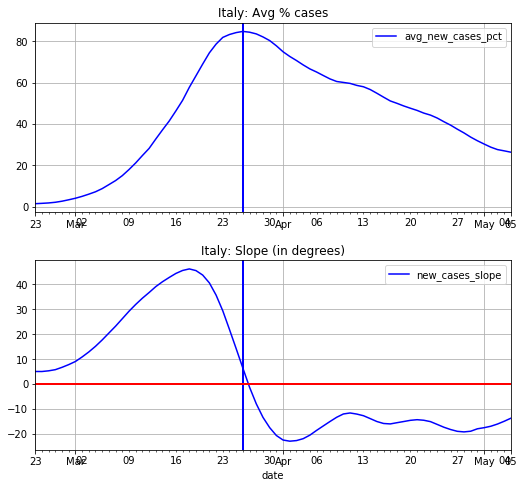

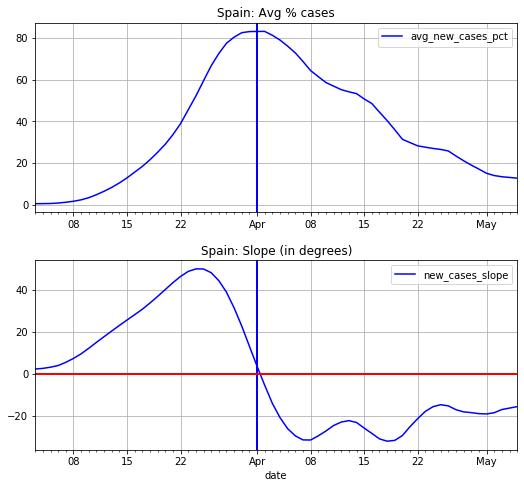

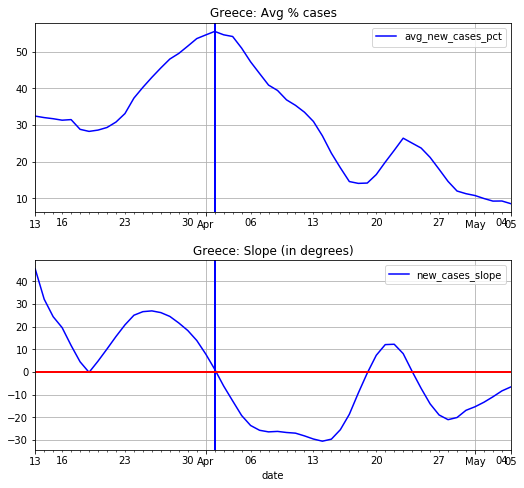

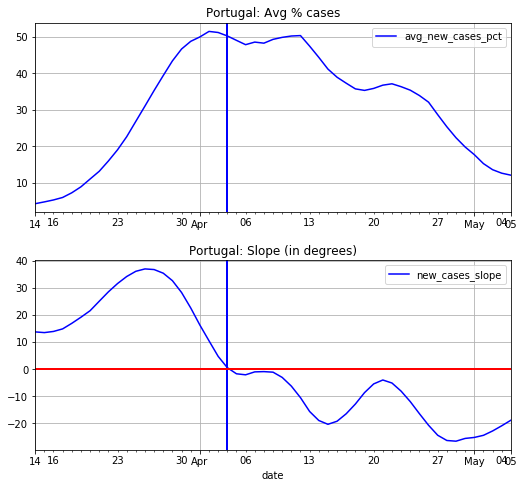

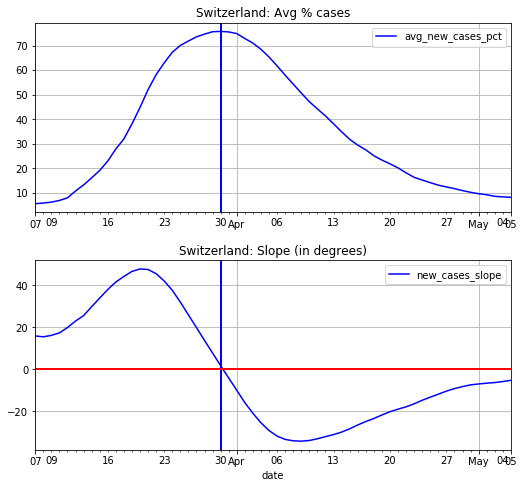

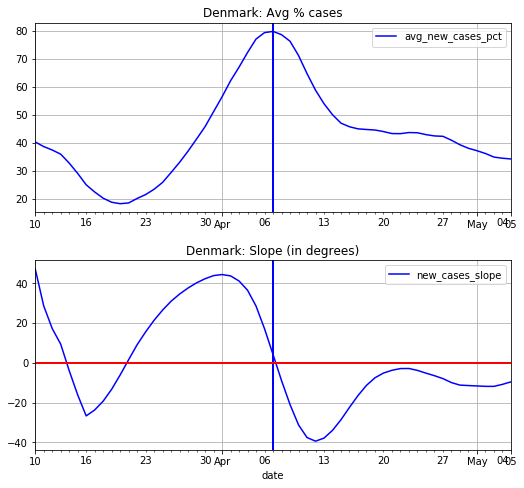

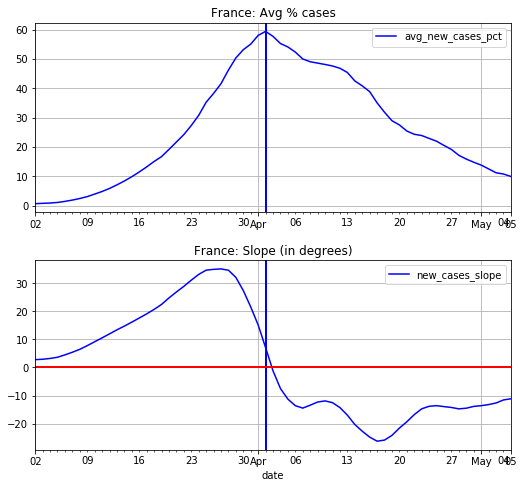

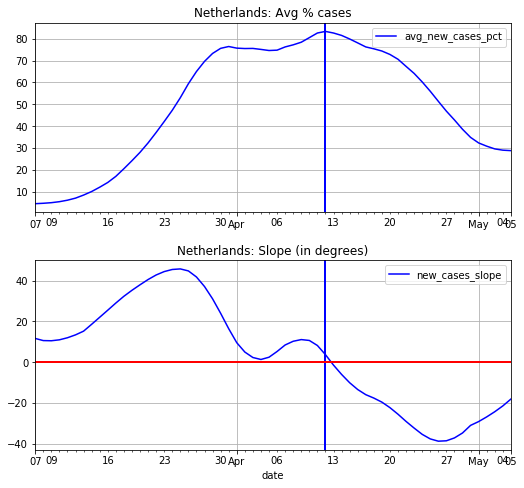

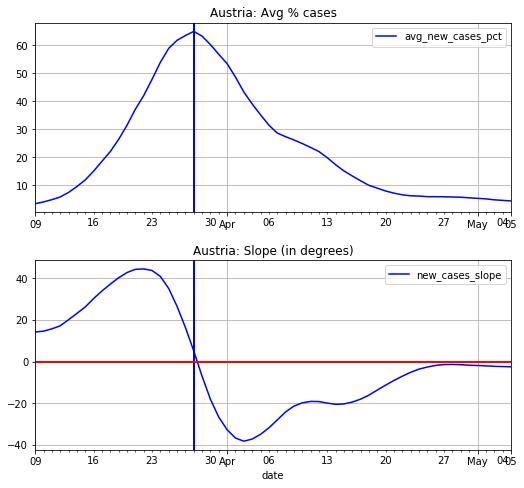

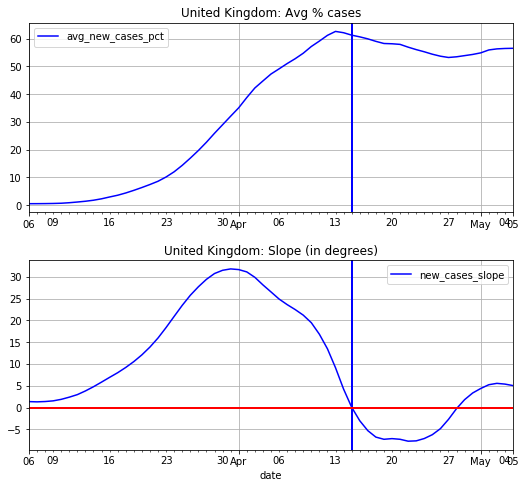

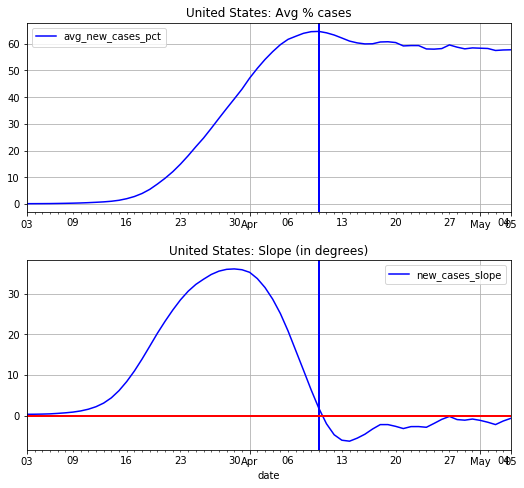

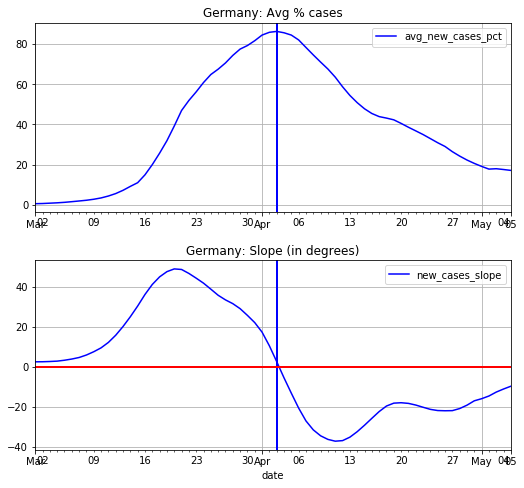

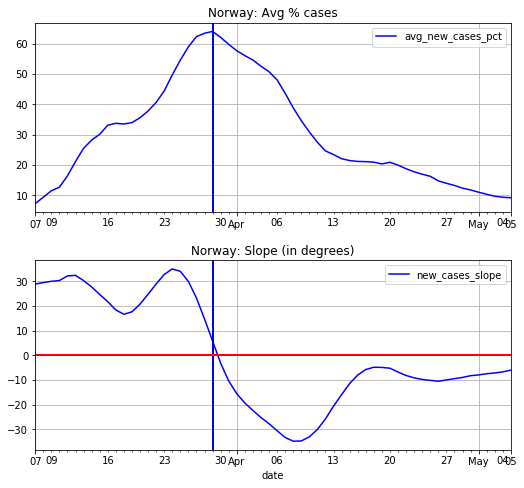

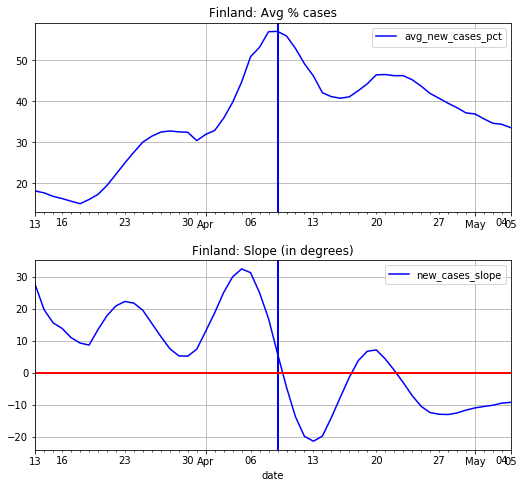

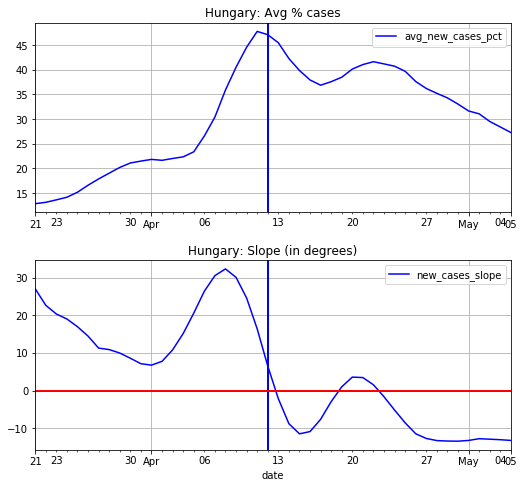

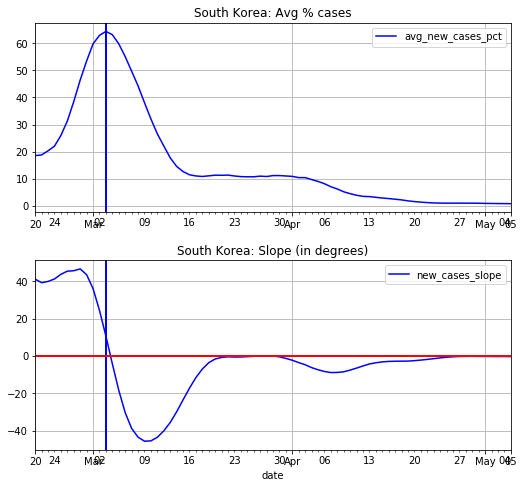

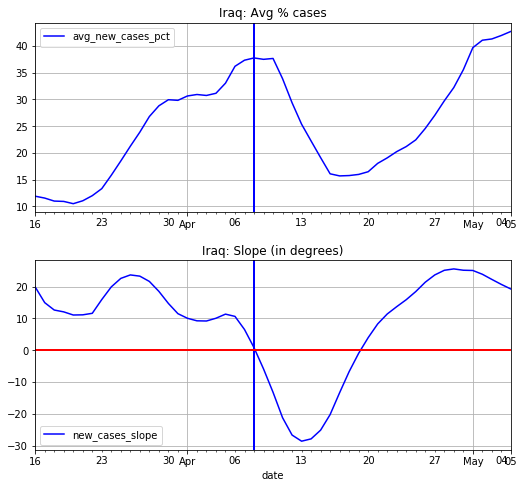

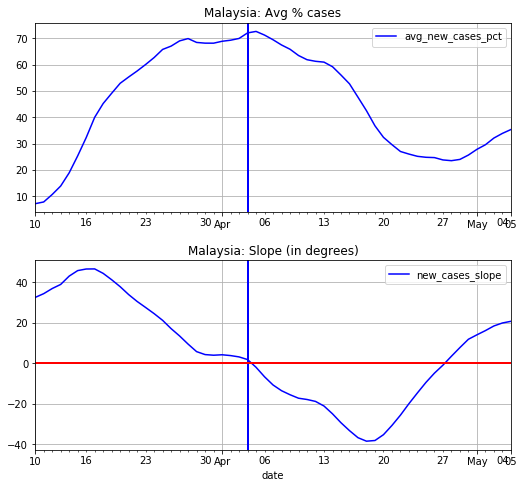

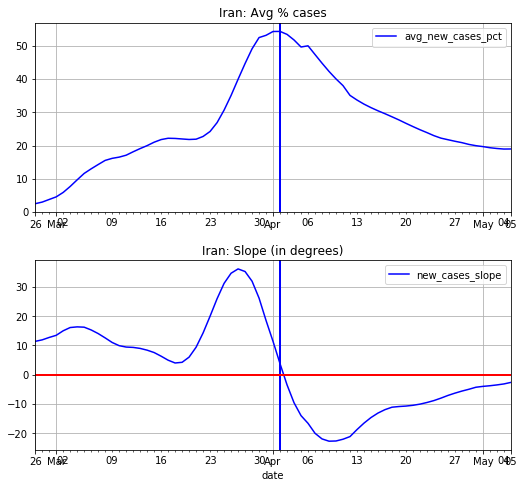

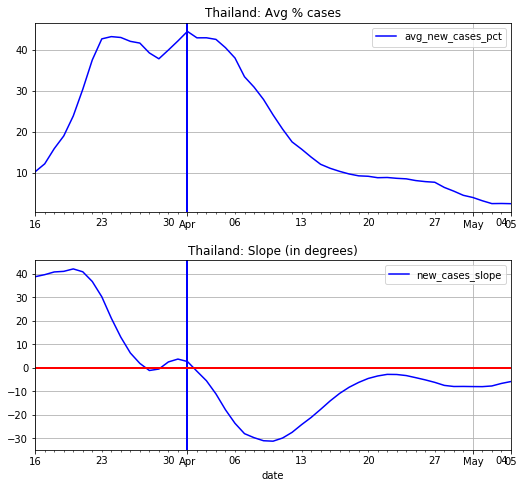

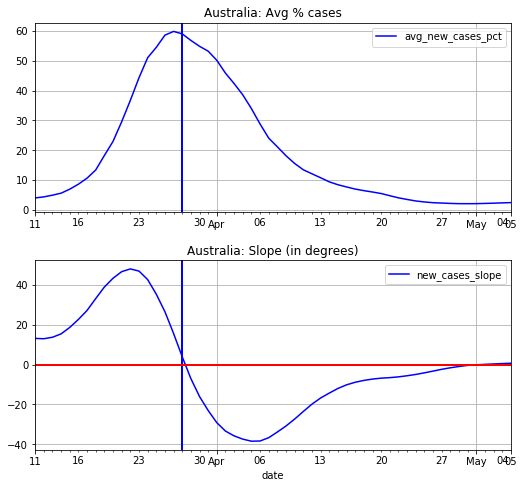

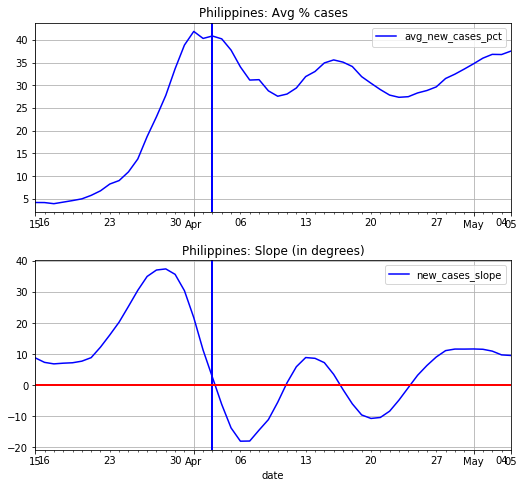

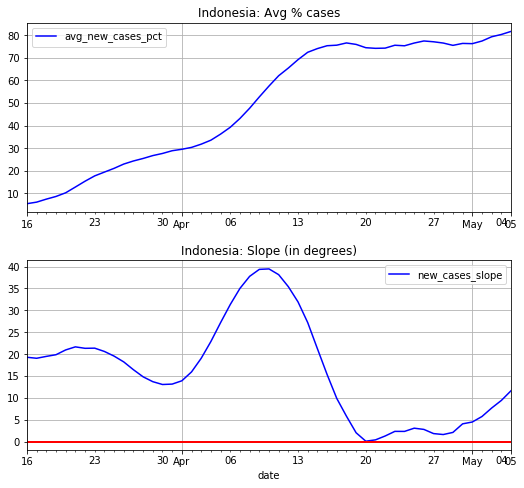

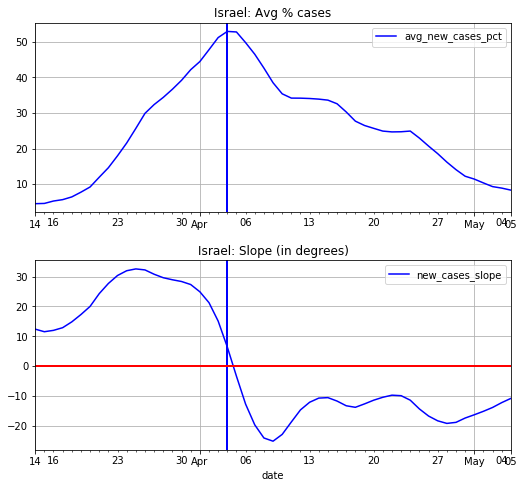

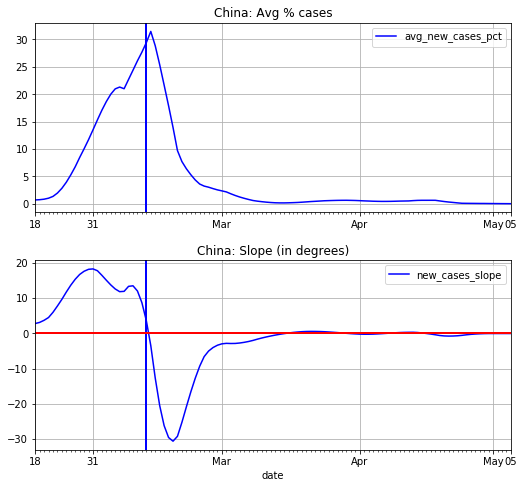

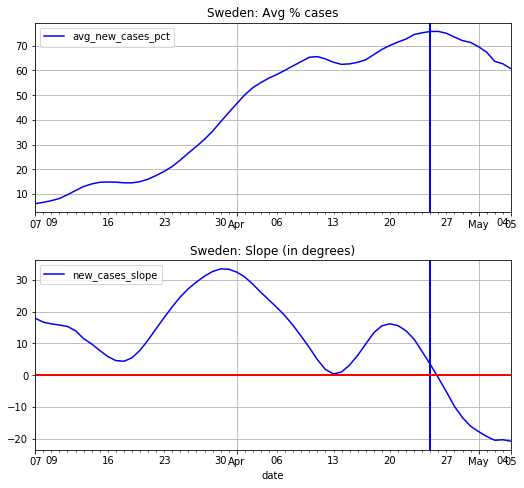

In [35]:
FIRST_WORLD = ["Italy","Spain","Estonia","Greece","Portugal","Switzerland","Denmark","France","Netherlands","Slovenia","Austria","United Kingdom","Belgium","Luxembourg","Czech Republic","United States","Germany","Croatia","Norway","Finland","Hungary"]
SECOND_WORLD = ["South Korea","Iraq","Malaysia","Iran","Serbia","Thailand","Australia","Morocco","Algeria","Macedonia","Ecuador","Argentina","Romania","Dominican Republic","Philippines","Indonesia","Colombia","Honduras","Israel","China","Panama","Turkey","Ukraine","Cameroon","Sweden","Japan","Cuba","South Africa","Ireland"]
BELOW_THRESHOLD = ["Singapore","Taiwan","Oman","Qatar","New zealand"]
PROBLEM = ["Bolivia","Egypt","Belarus","Bangladesh","Chile","Saudi Arabia"]
NOT_PEAKED = ["United Arab Emirates","Russia","Peru","Pakistan","Mexico","India","Brazil","Afghanistan"]
LAGGING = ["Poland","Moldova","Canada"]

# NOT_PEAKED_BLOG = NOT_PEAKED + ["Bangladesh", "Chile", "Saudi Arabia"]
PEAKED_BLOG = ["Italy","Spain","Greece","Portugal","Switzerland","Denmark","France","Netherlands","Austria","United Kingdom","United States","Germany","Norway","Finland","Hungary", "South Korea", "Iraq", "Malaysia", "Iran", "Thailand", "Australia", "Philippines", "Indonesia", "Israel", "China", "Sweden"]

for c in PEAKED_BLOG:
    _ = calc_peaks(fdf, c, False, True, True)

# _ = calc_peaks(fdf, "Saudi Arabia", False, True, False)

## India statewise analysis: COVID19 Data

In [29]:
import requests

# download data
rd1 = requests.get("https://api.covid19india.org/raw_data1.json") #eod apr 19th
rd2 = requests.get("https://api.covid19india.org/raw_data2.json") #eod apr 26th
rd3 = requests.get("https://api.covid19india.org/raw_data3.json") #eod apr 26th

In [37]:
# make dfs
df1 = pd.DataFrame(rd1.json()['raw_data'])
df2 = pd.DataFrame(rd2.json()['raw_data'])
df3 = pd.DataFrame(rd3.json()['raw_data'])

for df in [df1, df2, df3]:
    df.loc[df['detecteddistrict']=="Mumbai", "detectedstate"] = "Mumbai"

In [33]:
def get_state_df(df1, df2, df3, state):
    """utility function to get state's timeseries, given raw_data.json 1,2,3"""
    
    # datetime formatting
    df1['dateannounced'] = pd.to_datetime(df1['dateannounced'], dayfirst=True)
    df2['dateannounced'] = pd.to_datetime(df2['dateannounced'], dayfirst=True)
    df3['dateannounced'] = pd.to_datetime(df3['dateannounced'], dayfirst=True)

    # prep df1
    sdf1 = df1.loc[df1['detectedstate']==state][:]
    sdf1 = sdf1[['dateannounced', 'patientnumber']].groupby(by='dateannounced').count()
    sdf1 = sdf1.reset_index().rename(columns={'patientnumber': 'new_cases', 'dateannounced': 'date'})

    # prep df2
    sdf2 = df2.loc[df2['detectedstate']==state][:]
    sdf2 = sdf2[['dateannounced', 'patientnumber']].groupby(by='dateannounced').count()
    sdf2 = sdf2.reset_index().rename(columns={'patientnumber': 'new_cases', 'dateannounced': 'date'})

    # prep df3
    sdf3 = df3.loc[(df3['detectedstate']==state) & (df3['currentstatus']=='Hospitalized')][:]
    sdf3['numcases'] = sdf3['numcases'].astype('int64')
    sdf3 = sdf3[['dateannounced', 'numcases']].groupby(by='dateannounced').sum()
    sdf3 = sdf3.reset_index().rename(columns={'numcases': 'new_cases', 'dateannounced': 'date'})

    # join
    sdf = sdf1.append([sdf2, sdf3], sort=True)
    sdf['location'] = state
    
    return sdf

STATE: Kerala
STATE: Delhi
STATE: Telangana
STATE: Rajasthan
STATE: Haryana
STATE: Uttar Pradesh
STATE: Ladakh
new_cases sum less than 50. Skipping.
STATE: Tamil Nadu
STATE: Jammu and Kashmir
STATE: Karnataka
STATE: Maharashtra
STATE: Punjab
STATE: Mumbai
STATE: Andhra Pradesh
STATE: Uttarakhand
STATE: Odisha
STATE: Puducherry
new_cases sum less than 50. Skipping.
STATE: West Bengal
STATE: Chandigarh
STATE: Chhattisgarh
STATE: Gujarat
STATE: Himachal Pradesh
new_cases sum less than 50. Skipping.
STATE: Madhya Pradesh
STATE: Bihar
STATE: Manipur
new_cases sum less than 50. Skipping.
STATE: Mizoram


/home/mayank/Apps/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


new_cases sum less than 50. Skipping.
STATE: Goa
new_cases sum less than 50. Skipping.
STATE: Andaman and Nicobar Islands
new_cases sum less than 50. Skipping.
STATE: Jharkhand


/home/mayank/Apps/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


STATE: Assam
new_cases sum less than 50. Skipping.
STATE: Arunachal Pradesh
new_cases sum less than 50. Skipping.
STATE: 
new_cases sum less than 50. Skipping.
STATE: Tripura
new_cases sum less than 50. Skipping.
STATE: Meghalaya
new_cases sum less than 50. Skipping.


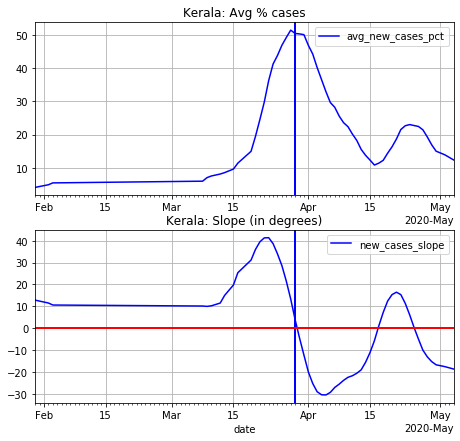

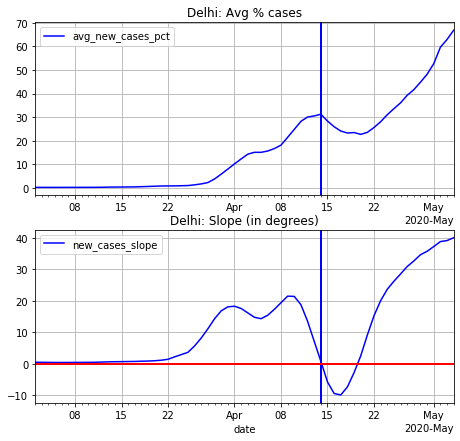

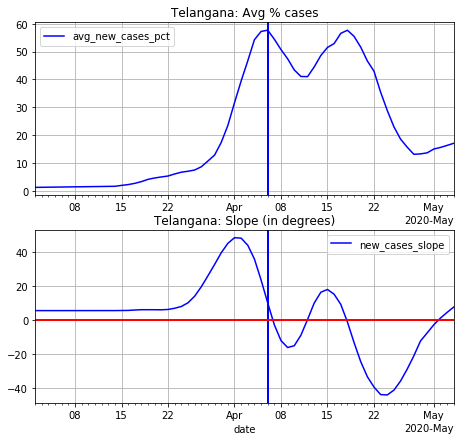

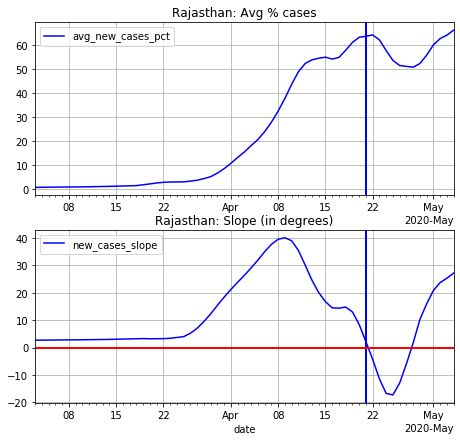

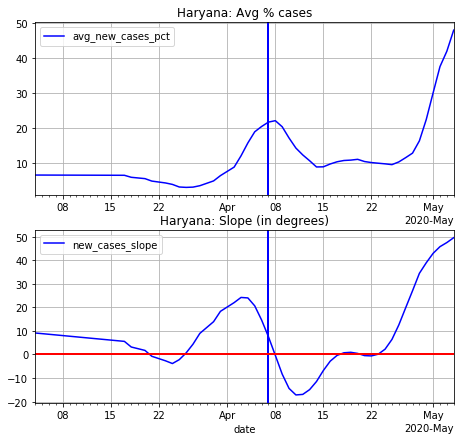

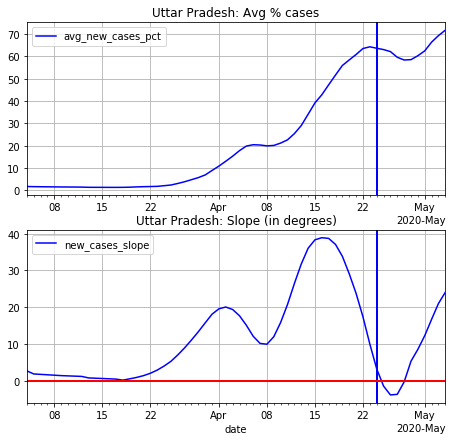

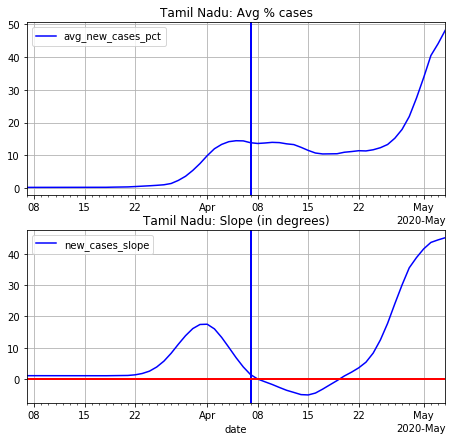

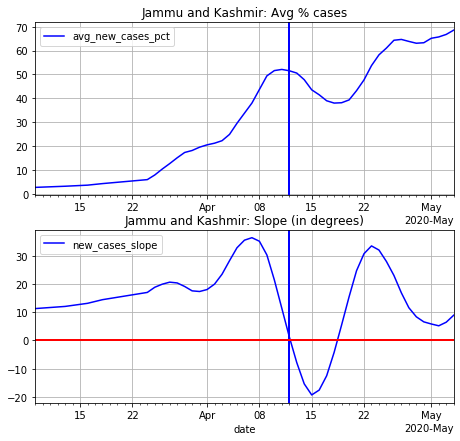

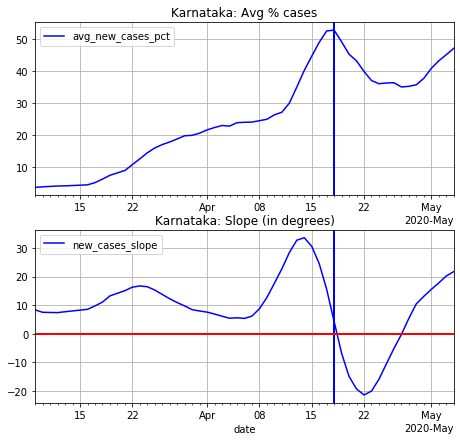

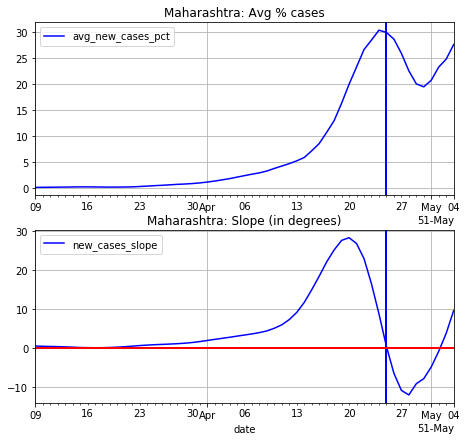

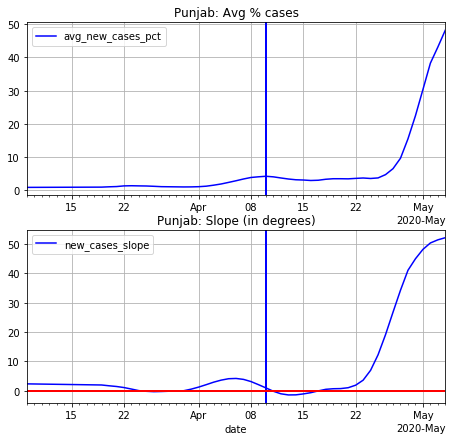

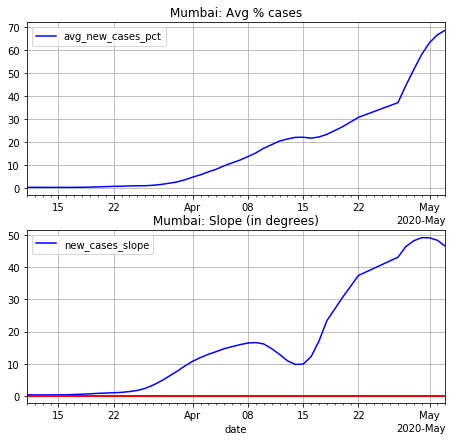

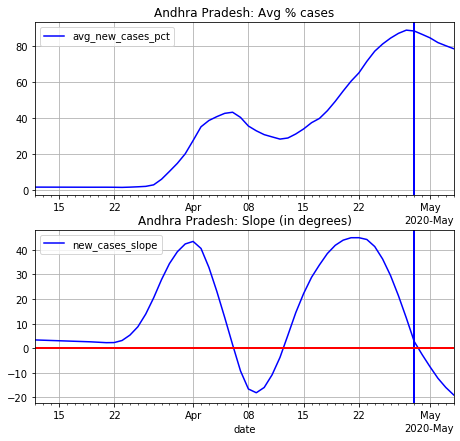

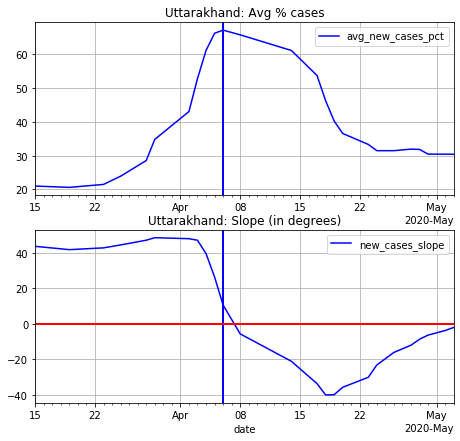

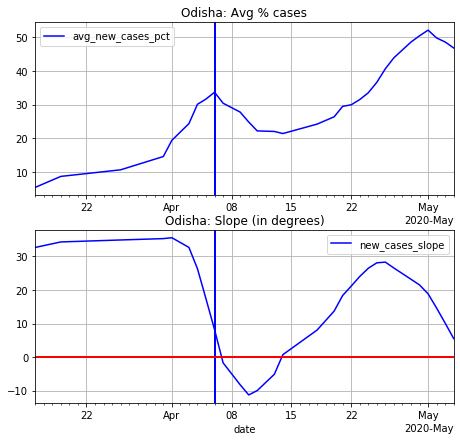

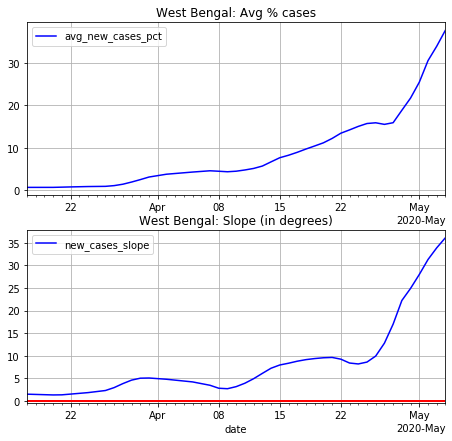

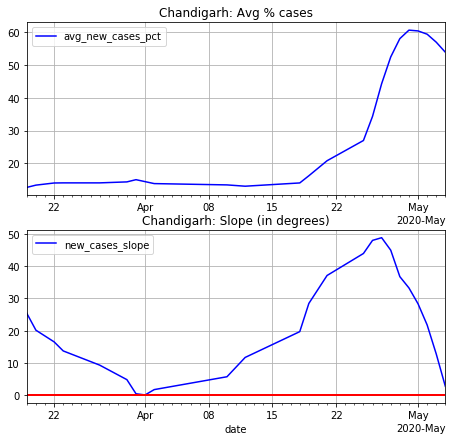

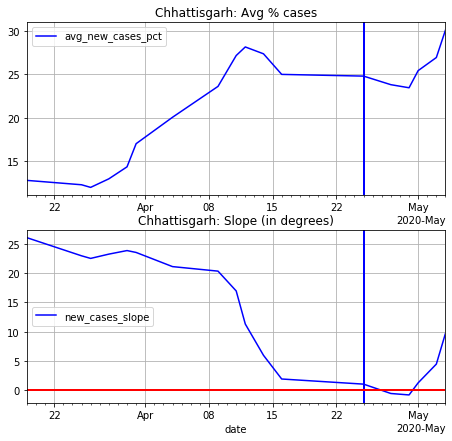

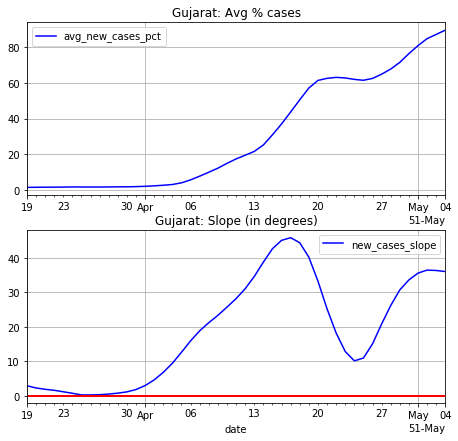

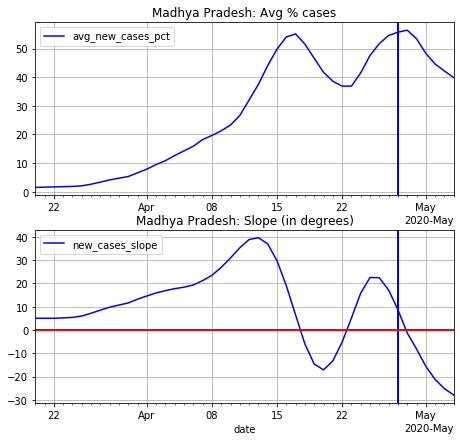

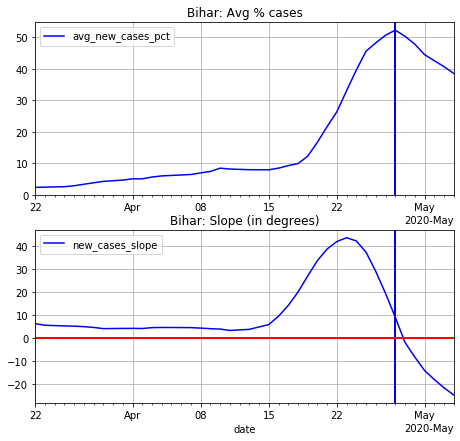

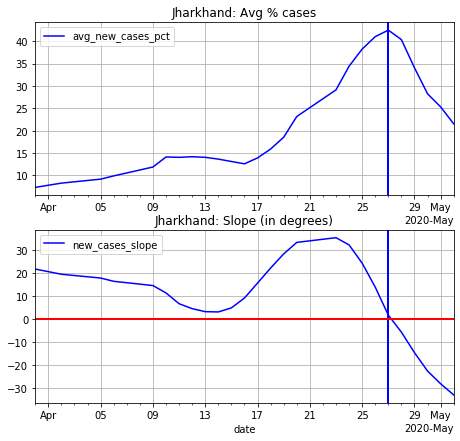

In [38]:
states = df1['detectedstate'].unique()

for state in states:
    print("STATE:", state)
    sdf = get_state_df(df1, df2, df3, state)
    _ = calc_peaks(sdf, state, deaths=False, plot=True, save=False)

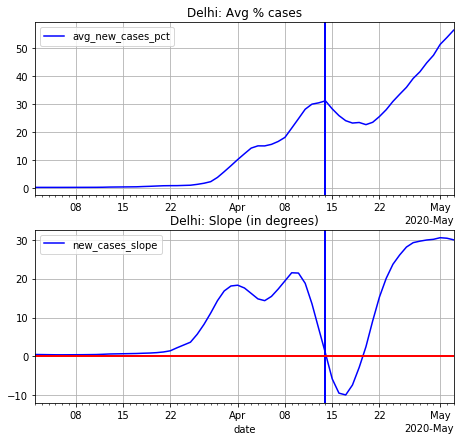

In [28]:
sdf = get_state_df(df1, df2, df3, 'Delhi')
_ = calc_peaks(sdf, 'Delhi', deaths=False, plot=True, save=False)